In [2]:
import random
from collections import OrderedDict
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import pubchempy as pcp

from Solvation_1.config import project_path
from Solvation_1.my_nets.Create_dataset import SS_Dataset
from Solvation_1.my_nets.LinearNet import LinearNet3
from Solvation_1.my_nets.net_func import load_ckp
from Solvation_1.Vectorizers.vectorizers import get_dictionary, get_sample, get_sdf_file
# from Solvation_1.Vectorizers.vectorizers import *

from sklearn.metrics import mean_squared_error as MSE
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import clone

from rdkit import RDLogger, Chem
from rdkit.Chem import AllChem

from chemreps.bagger import BagMaker
from chemreps.just_bonds import bonds

class my_datasets:
    def __init__(self):
        self.ds = []
        self.X = np.array([])
        self.y = np.array([])

torch.random.manual_seed(212)
random.seed(212)
np.random.seed(212)

create_manually = False

# Create datasets of MNSol

## Class - Morgan dataset

In [3]:
solvent_vectorizer = 'Classification'
solute_vectorizer = 'Morgan_fp_2_124'
norm_bools = (True, True, True)

In [237]:
Class_to_i = {}
class_dict1 = OrderedDict({1: 3, 2: 19, 3: 8, 4: 5, 5: 2, 6: 3, 7: 3, 8: 0, 9: 3, 10: 7, 11: 4, 12: 2, 13: 7, 14: 2, 15: 0})
class_dict2 = OrderedDict({2: {1: 6, 2: 2, 4: 2}, 3: {3: 2}, 4: {1: 2}})

tracker = 0
l1, l2, l3 = 0, 0, 0
for l1, count in class_dict1.items():
    l2, l3 = 0, 0
    Class_to_i[tracker] = np.array((l1, l2, l3))
    tracker += 1
    if l1 not in class_dict2:
        for l2 in range(1, count+1):
            Class_to_i[tracker] = np.array((l1, l2, l3))
            tracker+=1
    else:
        tr = 0
        l2 += 1
        while tr<count:
            Class_to_i[tracker] = np.array((l1, l2, l3))
            tracker+=1
            tr+=1
            if l2 in class_dict2[l1]:
                for l3 in range(1, class_dict2[l1][l2]+1):
                    Class_to_i[tracker] = np.array((l1, l2, l3))
                    tracker+=1
                    tr+=1
                l2+=1
                l3=0
            else:
                l2+=1

In [4]:
table_v1 = pd.read_table(project_path('Solvation_1/Tables/SS_table_v3.tsv'))
dataset = SS_Dataset(table_v1, solvent_vectorizer, solute_vectorizer, normalize=norm_bools)
len_data = dataset.__len__()
val_data = len_data // 10
train_dataset, val_dataset = dataset.train_val_split(0.9)

solvent_table = pd.read_table(project_path('Solvation_1/Tables/solvent_test_table_v3.tsv'))
solute_table = pd.read_table(project_path('Solvation_1/Tables/solute_test_table_v3.tsv'))
solvent_test_dataset = SS_Dataset(solvent_table, solvent_vectorizer, solute_vectorizer,
                                  normalize=norm_bools, show_norm_params=False)
solute_test_dataset = SS_Dataset(solute_table, solvent_vectorizer, solute_vectorizer,
                                 normalize=norm_bools, show_norm_params=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

solvent_test_loader = DataLoader(solvent_test_dataset, batch_size=46, shuffle=False)
solute_test_loader = DataLoader(solute_test_dataset, batch_size=64, shuffle=False)

print(f'train length: {len(train_loader.dataset)}')
print(f'val length: {len(val_loader.dataset)}')
print(f'solute test length: {len(solute_test_loader.dataset)}')
print(f'solvent test length: {len(solvent_test_loader.dataset)}')

MnSol_datasets={'Class_Morgan':{
    'train':train_dataset,
    'val': val_dataset,
    'solvent': solvent_test_dataset,
    'solute': solute_test_dataset}}

length check-> Solvent: 2529, Solute: 2529, G_solv: 2529

Solvent
 std: tensor([0.3608, 1.0000, 1.0000, 0.3608, 0.4860, 0.4812, 0.3938, 0.1118, 0.2118,
        1.0000, 1.0000, 0.3158, 0.3620, 0.3593, 0.0525, 0.2264, 0.1322, 1.0000,
        0.1322, 0.0525, 0.1337, 1.0000, 1.0000, 0.0793, 0.1392, 0.0525, 0.0628,
        0.0864, 0.0864, 1.0000, 0.0742, 1.0000, 1.0000, 0.1472, 0.0908, 0.0908,
        1.0000, 0.1168, 1.0000, 0.1047, 0.0487, 0.0929, 0.3271, 0.2980, 0.0628,
        0.1379, 0.1535, 0.1152, 1.0000, 0.1028, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.1065, 1.0000, 1.0000, 0.0768, 1.0000, 1.0000, 1.0000, 0.0742,
        0.0793, 0.0793, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.1065]) 
 mean: tensor([0.1538, 0.0000, 0.0000, 0.1538, 0.6180, 0.3638, 0.1918, 0.0127, 0.0471,
        0.0000, 0.0000, 0.1123, 0.1550, 0.1522, 0.0028, 0.0542, 0.0178, 0.0000,
        0.0178,

In [5]:
# save norm params for later
norms = {'Class_Morgan':MnSol_datasets['Class_Morgan']['solvent'].norm_params}

Distribution of G in subsets

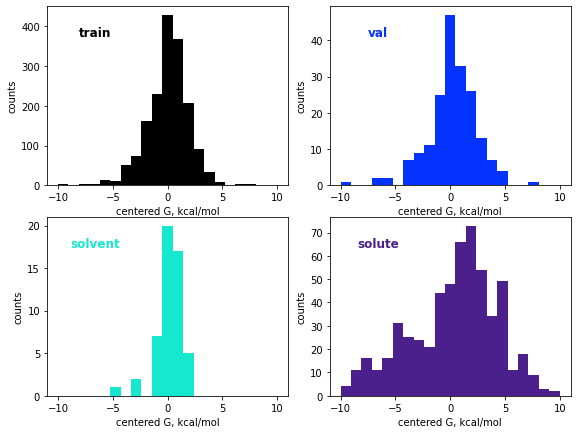

In [6]:
sp = (221, 222, 223, 224)
colors = [('black'), ('#0433FF'), ('#16E7CF'), ('#4B1F8C')]
labels = ['train', 'val', 'solvent', 'solute']
ds = (train_dataset, val_dataset, solvent_test_dataset, solute_test_dataset)
plt.subplots(2,2, figsize=(8, 6))
plt.style='scientific'
plt.tight_layout()
for i in range(4):
    plt.subplot(sp[i])
    plt.xlabel('centered G, kcal/mol')
    plt.ylabel('counts')
    # plt.text(0, 0 , labels[i], verticalalignment='top', horizontalalignment='left')
    # plt.title(labels[i], verticalalignment='top', horizontalalignment='left')
    # plt.text(.5,.9,labels[i],
    #     horizontalalignment='left')
    plt.title(labels[i], x=0.2, y=0.8, color=colors[i], fontweight = 'bold')
    plt.hist([x*2.8032 for x in ds[i].y], bins=21, range=(-10,10), color=colors[i])

plt.savefig('/Users/balepka/Downloads/MnSol_distr.png', dpi=300, bbox_inches='tight')


## JB - JB dataset

In [7]:
solvent_vectorizer = 'JustBonds'
solute_vectorizer = 'JustBonds'
norm_bools = (True, True, True)

In [8]:
dataset = SS_Dataset(table_v1, solvent_vectorizer, solute_vectorizer, normalize=norm_bools)
len_data = dataset.__len__()
val_data = len_data // 10
train_dataset, val_dataset = dataset.train_val_split(0.9)

solvent_table = pd.read_table(project_path('Solvation_1/Tables/solvent_test_table_v3.tsv'))
solute_table = pd.read_table(project_path('Solvation_1/Tables/solute_test_table_v3.tsv'))
solvent_test_dataset = SS_Dataset(solvent_table, solvent_vectorizer, solute_vectorizer,
                                  normalize=norm_bools, show_norm_params=False)
solute_test_dataset = SS_Dataset(solute_table, solvent_vectorizer, solute_vectorizer,
                                 normalize=norm_bools, show_norm_params=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

solvent_test_loader = DataLoader(solvent_test_dataset, batch_size=46, shuffle=False)
solute_test_loader = DataLoader(solute_test_dataset, batch_size=64, shuffle=False)

print(f'train length: {len(train_loader.dataset)}')
print(f'val length: {len(val_loader.dataset)}')
print(f'solute test length: {len(solute_test_loader.dataset)}')
print(f'solvent test length: {len(solvent_test_loader.dataset)}')

MnSol_datasets['JB_JB'] = {
    'train':train_dataset,
    'val': val_dataset,
    'solvent': solvent_test_dataset,
    'solute': solute_test_dataset}

length check-> Solvent: 2529, Solute: 2529, G_solv: 2529

Solvent
 std: tensor([3.8975e+02, 2.3588e+02, 1.7462e+02, 1.0000e+00, 1.3297e+01, 1.5867e+01,
        1.6703e+01, 1.6875e+01, 1.7781e+01, 1.7984e+01, 1.8188e+01, 1.7594e+01,
        1.4133e+01, 1.3164e+01, 1.1172e+01, 1.1172e+01, 1.0297e+01, 1.0297e+01,
        1.0297e+01, 1.0102e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.6750e+01, 1.0039e+01, 7.4844e+00, 1.0000e+00, 1.0625e+01,
        1.1141e+01, 1.1555e+01, 1.1797e+01, 1.2016e+01, 1.2172e+01, 1.1484e+01,
        9.6953e+00, 8.7734e+00, 7.7891e+00, 7.4062e+00, 6.6992e+00, 6.5977e+00,
        6.5977e+00, 6.4727e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.4675e+02, 1.3612e+02,
        1.2056e+02, 8.2688e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.8953e+01, 1.7547e+01, 1.5562e+01, 1.0688e+01, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.00

In [9]:
# saving norms for later
norms['JB_JB'] = MnSol_datasets['JB_JB']['solvent'].norm_params

# Acree database

## Create Solvent - Solute - G list

In [12]:
with open(project_path('Solvation_1/Tables/Acree/data_kcal.pkl'), 'rb') as f:
    Acree_data = pkl.load(f)

## Distribution G

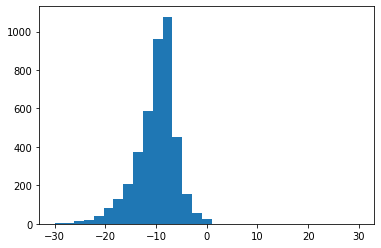

In [13]:
Acree_Gs = []
for Solvent, value in Acree_data.items():
    for key, G in value.items():
        Acree_Gs.append(G)

plt.hist(Acree_Gs, bins=31, range=(-30,30))
plt.show()

## Solvent Classification

In [14]:
with open(project_path('Solvation_1/Tables/Acree/Solvent_Class.pkl'), 'rb') as f:
    Acree_Solvent_classes = pkl.load(f)

## Morgan fingerprints

In [15]:
with open(project_path('Solvation_1/Tables/Acree/Solute_SMILES.pkl'), 'rb') as f:
    Acree_Solute_SMILES = pkl.load(f)

In [16]:
if create_manually:
    def create_morgan_tensor(compound_smiles, params):
        RDLogger.DisableLog('rdApp.*')  # disables WARNING of not removing H-atoms
        radius, nBits, chiral = params
        smiles = compound_smiles
        mol = Chem.MolFromSmiles(smiles)  # get compound molecule instance
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, useChirality=chiral, radius=radius, nBits=nBits)  # get fingerprints
        out = torch.tensor(fp, dtype=torch.float)
        return out

    Acree_Solute_morgan = {}
    for name, smiles in Acree_Solute_SMILES.items():
        morgan = create_morgan_tensor(smiles, (2, 124, False))
        Acree_Solute_morgan[name] = morgan

    with open(project_path('Solvation_1/Tables/Acree/Solute_morgan.pkl'), 'wb') as f:
        pkl.dump(Acree_Solute_morgan, f)

In [17]:
# creating dataset
if not create_manually:
    with open(project_path('Solvation_1/Tables/Acree/Solute_morgan.pkl'), 'rb') as f:
        Acree_Solute_morgan = pkl.load(f)

Acree_Class_Morgan = my_datasets()
for Solvent, values in Acree_data.items():
    for solute, G in values.items():
        try:
            S_vect = (Acree_Solvent_classes[Solvent]-norms['Class_Morgan']['Solvent'][1])/norms['Class_Morgan']['Solvent'][0]
            U_vect = (Acree_Solute_morgan[solute]-norms['Class_Morgan']['Solute'][1])/norms['Class_Morgan']['Solute'][0]
            X = torch.concat((S_vect, U_vect))
            y = (G-norms['Class_Morgan']['G'][1])/norms['Class_Morgan']['G'][0]
            Acree_Class_Morgan.ds.append((X, y))
            try:
                Acree_Class_Morgan.X = np.vstack((Acree_Class_Morgan.X, np.array(X)))
                Acree_Class_Morgan.y = np.vstack((Acree_Class_Morgan.y, float(y)))
            except ValueError:
                Acree_Class_Morgan.X = np.array(X)
                Acree_Class_Morgan.y = np.array(float(y))
        except KeyError:
            print(f'S: {Solvent}, U: {solute}')

Acree_Class_Morgan.dl = DataLoader(Acree_Class_Morgan.ds)

S: Ethanol, U: 2-Methylpyridine (alpha-Picoline)


## JB-JB

In [20]:
dataset = project_path('Solvation_1/Tables/Reserve/Sdf')
bagger = BagMaker('JustBonds', dataset)

# Create dictionary of i to bags for later
JB_bag_i = {}
tracker = 0

for bag, size in bagger.bag_sizes.items():
    for j in range(size+1):
        JB_bag_i[tracker] = (bag, j)
        tracker+=1

In [21]:
if create_manually:
    Acree_JB_data = {}
    for compound in list(Acree_data.keys()):
        filename = compound.strip()
        filename = filename.replace('"', '$')
        filename = filename.replace("'", '$')
        filename = filename.replace(' ', '&')
        filename = filename.replace(',', '_')
        mol_path = project_path(f'Solvation_1/Tables/Acree/SDF/Solvents/{filename}.sdf')
        JB_array = bonds(mol_path, bagger.bags, bagger.bag_sizes)
        out = torch.tensor(JB_array)
        Acree_JB_data[compound] = out


    exception_list = ['Glycerol', '1,2,3,5-Tetrabromobenzene', 'Benzo-15-crown-5', '15-Crown-5', '18-Crown-6', 'Dibenzo 18-Crown-6', 'Chlorine gas', 'Tetraglyme']
    for compound in list(Acree_Solute_SMILES.keys()):
        if compound not in exception_list:
            # print(f'{compound}')
            filename = compound.strip()
            filename = filename.replace('"', '$')
            filename = filename.replace("'", '$')
            filename = filename.replace(' ', '&')
            filename = filename.replace(',', '_')
            mol_path = project_path(f'Solvation_1/Tables/Acree/SDF/Solutes/{filename}.sdf')
            try:
                JB_array = bonds(mol_path, bagger.bags, bagger.bag_sizes)
                out = torch.tensor(JB_array)
                Acree_JB_data[compound] = out
            except FileNotFoundError:
                print(f'fnf {compound}')
            except Exception:
                print(f'Ex!!! {compound}')

    with open(project_path('Solvation_1/Tables/Acree/Acree_JB_data.pkl'), 'wb') as f:
        pkl.dump(Acree_JB_data, f)

In [22]:
if not create_manually:
    with open(project_path('Solvation_1/Tables/Acree/Acree_JB_data.pkl'), 'rb') as f:
        Acree_JB_data = pkl.load(f)

In [23]:
Acree_JB_JB = my_datasets()
for Solvent, values in Acree_data.items():
    for solute, G in values.items():
        S_vect = (Acree_JB_data[Solvent]-norms['JB_JB']['Solvent'][1])/norms['JB_JB']['Solvent'][0]
        try:
            U_vect = (Acree_JB_data[solute]-norms['JB_JB']['Solute'][1])/norms['JB_JB']['Solute'][0]
            X = torch.concat((S_vect, U_vect))
            y = (G-norms['JB_JB']['G'][1])/norms['JB_JB']['G'][0]
            Acree_JB_JB.ds.append((X, y))
            try:
                Acree_JB_JB.X = np.vstack((Acree_JB_JB.X, np.array(X)))
                Acree_JB_JB.y = np.vstack((Acree_JB_JB.y, float(y)))
            except ValueError:
                Acree_JB_JB.X = np.array(X)
                Acree_JB_JB.y = np.array(float(y))

        except KeyError or FileNotFoundError:
            print(f'S: {Solvent}, U: {solute}')

S: 1-Propanol, U: 15-Crown-5
S: 1-Propanol, U: 18-Crown-6
S: 1-Propanol, U: Benzo-15-crown-5
S: 1-Butanol, U: 15-Crown-5
S: 1-Butanol, U: 18-Crown-6
S: 2-Propanol, U: 15-Crown-5
S: 2-Propanol, U: 18-Crown-6
S: Tetrahydrofuran, U: 15-Crown-5
S: 1,4-Dioxane, U: 15 Crown 5
S: 1,4-Dioxane, U: 18-Crown-6
S: Methanol, U: Propylene glycol 
S: Methanol, U: Glycerol
S: Methanol, U: 15-Crown-5
S: Methanol, U: 18-Crown-6
S: Ethanol, U: Propylene glycol 
S: Ethanol, U: 18-Crown-6
S: Ethanol, U: 2-Methylpyridine (alpha-Picoline)
S: Hexane, U: Tetraglyme
S: Heptane, U: Methyl heptyl ether 
S: Decane, U: Tetraglyme
S: Tetradecane, U: 15-Crown-5
S: Acetonitrile, U: 15-Crown-5
S: Acetone, U: Glycerol
S: Acetone, U: 15-Crown-5
S: Acetone, U: 18-Crown-6
S: Cyclohexane, U: 18-Crown-6
S: Benzene, U: Methyl heptyl ether 
S: Benzene, U: 15-Crown-5
S: Benzene, U: 18-Crown-6
S: Dimethyl sulfoxide, U: Methyl heptyl ether 
S: Dimethyl sulfoxide, U: 15-Crown-5
S: Dimethyl sulfoxide, U: 18-Crown-6
S: Dimethyl sulf

# FreeSolv database

## Create Solvent - Solute - G list

In [24]:
with open(project_path('Solvation_1/Tables/FreeSolv/database.pickle'), 'rb') as f:
    free_solv_dict = pkl.load(f)

In [25]:
FreeSolv_data_water = {free_solv_dict[x]['iupac']:free_solv_dict[x]['expt'] for x in free_solv_dict}
FreeSolv_data = {'water':{**FreeSolv_data_water}}

In [26]:
FS_Gs = list(FreeSolv_data_water.values())

## Distribution

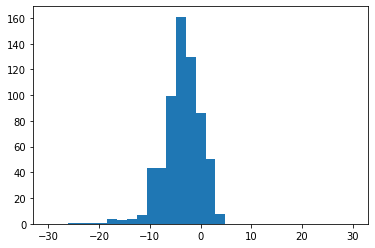

In [27]:
plt.hist(FS_Gs, bins=31, range=(-30, 30))
plt.show()

## Solvent Classification

In [29]:
t = torch.zeros_like(Acree_Solvent_classes['Ethanol'])
t[0] = 1
t[3] = 1
FS_Solvent_classes={'water':t}

## Morgan fingerprints

In [30]:
if create_manually:
    FS_SMILES = {free_solv_dict[x]['iupac']:free_solv_dict[x]['smiles'] for x in free_solv_dict}
    FS_Solute_morgan = {}
    for name, smiles in FS_SMILES.items():
        morgan = create_morgan_tensor(smiles, (2, 124, False))
        FS_Solute_morgan[name] = morgan

    with open(project_path('Solvation_1/Tables/FreeSolv/FS_Solute_morgan.pkl'), 'wb') as f:
        pkl.dump(FS_Solute_morgan, f)
    with open(project_path('Solvation_1/Tables/FreeSolv/FS_SMILES.pkl'), 'wb') as f:
        pkl.dump(FS_SMILES, f)

In [31]:
if not create_manually:
    with open(project_path('Solvation_1/Tables/FreeSolv/FS_Solute_morgan.pkl'), 'rb') as f:
        FS_Solute_morgan = pkl.load(f)
    with open(project_path('Solvation_1/Tables/FreeSolv/FS_SMILES.pkl'), 'rb') as f:
        FS_SMILES = pkl.load(f)

In [32]:
# creating dataset
# only water in Solvents in FreeSolv
FS_Class_Morgan = my_datasets()
for solute, G in FreeSolv_data['water'].items():
    S_vect = (FS_Solvent_classes['water']-norms['Class_Morgan']['Solvent'][1])/norms['Class_Morgan']['Solvent'][0]
    U_vect = (FS_Solute_morgan[solute]-norms['Class_Morgan']['Solute'][1])/norms['Class_Morgan']['Solute'][0]
    X = torch.concat((S_vect, U_vect))
    y = (G-norms['Class_Morgan']['G'][1])/norms['Class_Morgan']['G'][0]
    FS_Class_Morgan.ds.append((X, y))
    try:
        FS_Class_Morgan.X = np.vstack((FS_Class_Morgan.X, np.array(X)))
        FS_Class_Morgan.y = np.vstack((FS_Class_Morgan.y, float(y)))
    except ValueError:
        FS_Class_Morgan.X = np.array(X)
        FS_Class_Morgan.y = np.array(float(y))

FS_Class_Morgan.dl = DataLoader(FS_Class_Morgan.ds)

## JB - JB

In [34]:
if create_manually:
    for name, smiles in FS_SMILES.items():
        filename = name.replace('"', '$')
        filename = filename.replace("'", '$')
        filename = filename.replace(' ', '&')
        filename = filename.replace(',', '_')
        path = project_path(f'Solvation_1/Tables/FreeSolv/SDF/{filename}.sdf')
        try:
            pcp.download('SDF', path, name, 'name', record_type='3d', overwrite=True)
        except:
            try:
                pcp.download('SDF', path, smiles, 'smiles', record_type='3d', overwrite=True)
            except:
                with open(project_path('Solvation_1/Tables/FreeSolv/SDF/missing.txt'), 'a') as f:
                    f.write(f'{name}\t{smiles}\n')

In [35]:
if create_manually:
    FS_JB_data = {}
    exception_list = ['methanesulfonyl chloride',
                      '(2R,3R,4S,5S,6R)-6-(hydroxymethyl)tetrahydropyran-2,3,4,5-tetrol',
                      '(2S,3R,4S,5R)-oxane-2,3,4,5-tetrol',
                      '1,2,3,4,5-pentachloro-6-(2,3,4,5,6-pentachlorophenyl)benzene',
                      'dimethyl sulfate',
                      'glycerol',
                      '(2R,3R,4R,5R)-Hexan-1,2,3,4,5,6-hexol',
                      '1,3-bis-(nitrooxy)butane',
                      'chlordane'
    ]
    for compound in list(FS_SMILES.keys()):
        if compound not in exception_list:
            # print(f'{compound}')
            filename = compound.strip()
            filename = filename.replace('"', '$')
            filename = filename.replace("'", '$')
            filename = filename.replace(' ', '&')
            filename = filename.replace(',', '_')
            mol_path = project_path(f'Solvation_1/Tables/FreeSolv/SDF/Solutes/{filename}.sdf')
            try:
                JB_array = bonds(mol_path, bagger.bags, bagger.bag_sizes)
                out = torch.tensor(JB_array)
                FS_JB_data[compound] = out
            except FileNotFoundError:
                print(f'fnf {compound}')
            except Exception:
                print(f'Ex!!! {compound}')

    JB_array = bonds(project_path(f'Solvation_1/Tables/FreeSolv/SDF/Solvents/Water.sdf'),
                     bagger.bags, bagger.bag_sizes)
    out = torch.tensor(JB_array)
    FS_JB_data['Water'] = out

    with open(project_path('Solvation_1/Tables/FreeSolv/FS_JB_data.pkl'), 'wb') as f:
        pkl.dump(FS_JB_data, f)


In [36]:
if not create_manually:
    with open(project_path('Solvation_1/Tables/FreeSolv/FS_JB_data.pkl'), 'rb') as f:
        FS_JB_data = pkl.load(f)

In [37]:
FS_JB_JB = my_datasets()
FS_JB_JB_pairs = []
for solute, G in FreeSolv_data['water'].items():
    S_vect = (FS_JB_data['Water']-norms['JB_JB']['Solvent'][1])/norms['JB_JB']['Solvent'][0]
    try:
        U_vect = (FS_JB_data[solute]-norms['JB_JB']['Solute'][1])/norms['JB_JB']['Solute'][0]
        X = torch.concat((S_vect, U_vect))
        y = (G-norms['JB_JB']['G'][1])/norms['JB_JB']['G'][0]
        FS_JB_JB.ds.append((X, y))
        try:
            FS_JB_JB.X = np.vstack((FS_JB_JB.X, np.array(X)))
            FS_JB_JB.y = np.vstack((FS_JB_JB.y, float(y)))
        except ValueError:
            FS_JB_JB.X = np.array(X)
            FS_JB_JB.y = np.array(float(y))
        FS_JB_JB_pairs.append(('water', solute))
    except KeyError:
        print(solute)


methanesulfonyl chloride
chlordane
(2S,3R,4S,5R)-oxane-2,3,4,5-tetrol
1,2,3,4,5-pentachloro-6-(2,3,4,5,6-pentachlorophenyl)benzene
dimethyl sulfate
glycerol
(2R,3R,4R,5R)-Hexan-1,2,3,4,5,6-hexol
1,3-bis-(nitrooxy)butane
(2R,3R,4S,5S,6R)-6-(hydroxymethyl)tetrahydropyran-2,3,4,5-tetrol


# Scores on various datasets

## Load models

In [55]:
with open('/Users/balepka/PycharmProjects/msuAI/Solvation_1/Run_results/Class_Morgan_KRR1/best_models.pkl', 'rb') as f:
    KRR_Class_Morgan_kernels = pkl.load(f)
KRR_Class_Morgan = KRR_Class_Morgan_kernels['laplacian']

with open('/Users/balepka/PycharmProjects/msuAI/Solvation_1/Run_results/JB_JB_KRR1/best_models.pkl', 'rb') as f:
    KRR_JB_JB_kernels = pkl.load(f)
KRR_JB_JB = KRR_JB_JB_kernels['laplacian']

# load checkpoint
in_feat = MnSol_datasets['Class_Morgan']['train'].X[0].__len__()
model = LinearNet3(in_features=in_feat)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
LinNet_Class_Morgan, *other = load_ckp('Solvation_1/Runs/Class_Morgan_Lin1/best/best_val_model.pt', model, optimizer)


## KRR RMS

### MnSol

In [193]:
def plot_one(y_true, y_pred):
    plt.style = 'scientific'
    plt.figure(figsize=(11,5))

    plt.subplot(121)
    plt.scatter(y_true, y_pred)
    plt.x_lim = (-5,3)
    plt.y_lim = (-5,3)

    plt.subplot(122)
    plt.scatter(y_true, y_pred-y_true)

    plt.show()

train KRR Class Morgan
RMS: 0.3470169102873393


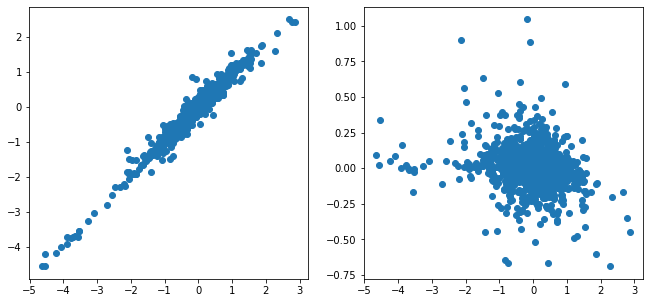

val KRR Class Morgan
RMS: 0.2859936372738795


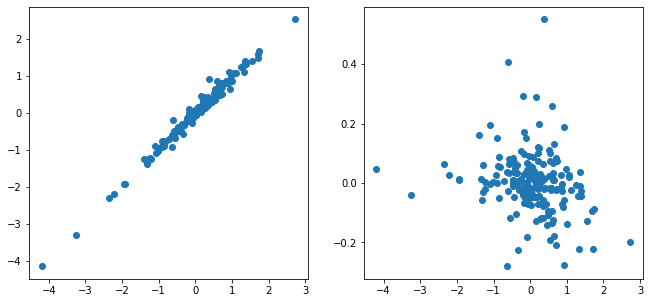

solvent KRR Class Morgan
RMS: 0.3781091351403688


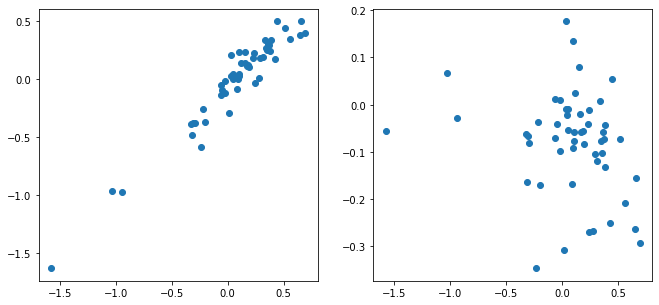

solute KRR Class Morgan
RMS: 3.02340427810634


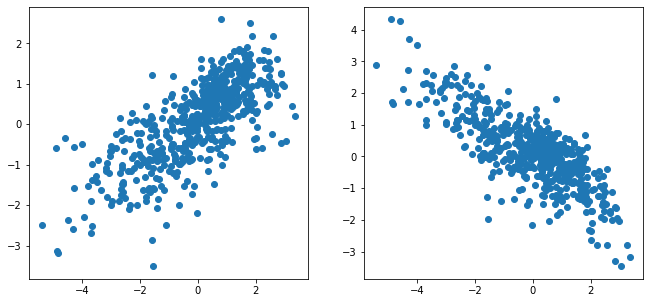

In [194]:
for name, ds in MnSol_datasets['Class_Morgan'].items():
    print(f'{name} KRR Class Morgan')
    y_pred = KRR_Class_Morgan.predict(ds.X)
    y_true = ds.y
    MSE_score = MSE(y_true, y_pred)
    RMS = float(MSE_score**0.5*norms['Class_Morgan']['G'][0])
    print(f'RMS: {RMS}')
    plot_one(y_true, y_pred)


train KRR JB JB
RMS: 0.20251928478924044


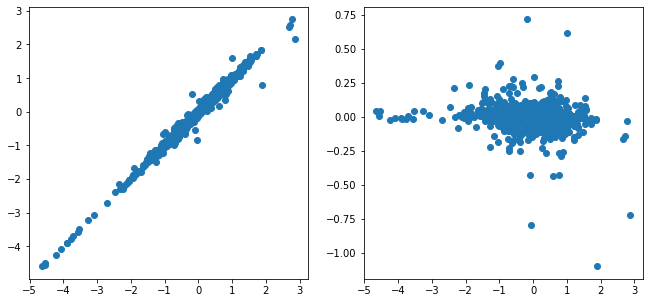

val KRR JB JB
RMS: 0.1608912252894952


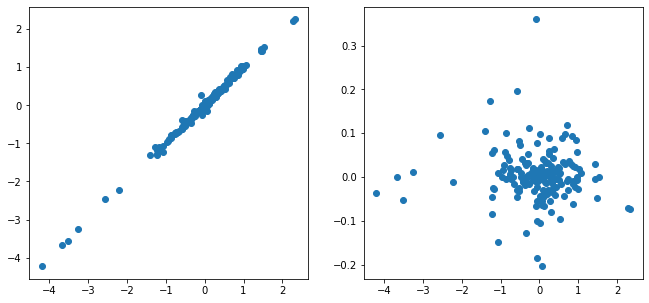

solvent KRR JB JB
RMS: 0.4531301447567181


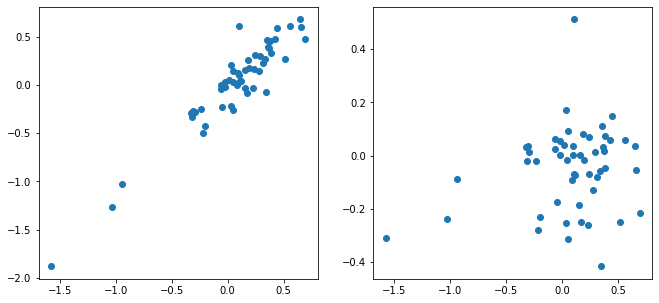

solute KRR JB JB
RMS: 1.8554273585079382


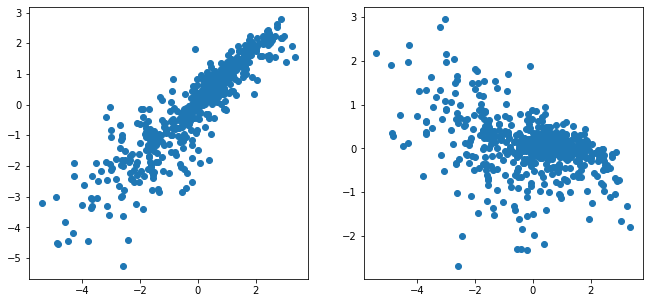

In [195]:
for name, ds in MnSol_datasets['JB_JB'].items():
    print(f'{name} KRR JB JB')
    y_pred = KRR_JB_JB.predict(ds.X)
    y_true = ds.y
    MSE_score = MSE(y_true, y_pred)
    RMS = float(MSE_score**0.5*norms['JB_JB']['G'][0])
    print(f'RMS: {RMS}')
    plot_one(y_true, y_pred)

### Acree

Acree KRR Class Morgan
RMS: 5.940


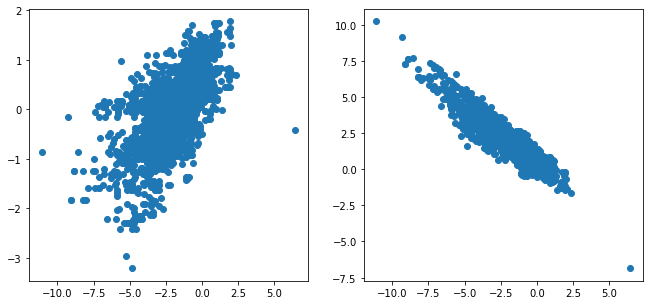

In [200]:
print('Acree KRR Class Morgan')
y_pred = KRR_Class_Morgan.predict(Acree_Class_Morgan.X)
y_true = Acree_Class_Morgan.y
MSE_score = MSE(y_true, y_pred)
RMS = MSE_score**0.5*norms['Class_Morgan']['G'][0]
print(f'RMS: {float(RMS):.3f}')
plot_one(np.squeeze(y_true), y_pred)


Acree KRR JB JB
RMS: 5.344


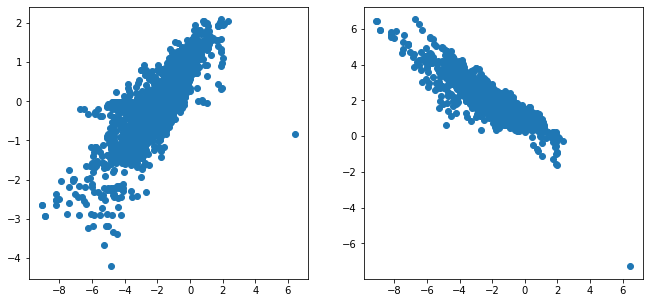

In [202]:
print('Acree KRR JB JB')
y_pred = KRR_JB_JB.predict(Acree_JB_JB.X)
y_true = Acree_JB_JB.y
MSE_score = MSE(y_true, y_pred)
RMS = MSE_score**0.5*norms['JB_JB']['G'][0]
print(f'RMS: {float(RMS):.3f}')
plot_one(np.squeeze(y_true), y_pred)

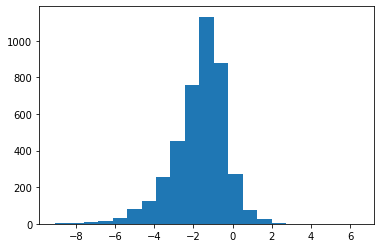

In [203]:
plt.hist(Acree_JB_JB.y, bins=21)
plt.show()

### FreeSolv

FreeSolv KRR Class Morgan
RMS: 2.983


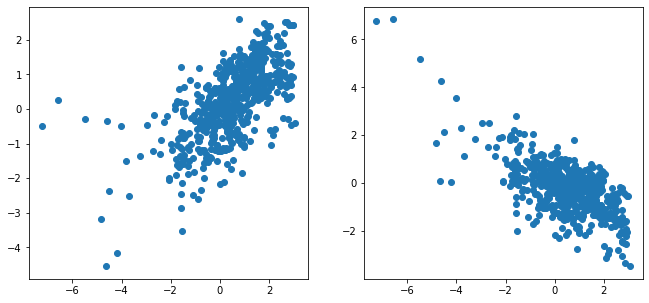

In [204]:
print('FreeSolv KRR Class Morgan')
y_pred = KRR_Class_Morgan.predict(FS_Class_Morgan.X)
y_true = FS_Class_Morgan.y
MSE_score = MSE(y_true, y_pred)
RMS = MSE_score**0.5*norms['Class_Morgan']['G'][0]
print(f'RMS: {float(RMS):.3f}')
plot_one(np.squeeze(y_true), y_pred)

FreeSolv KRR JB JB
RMS: 1.453


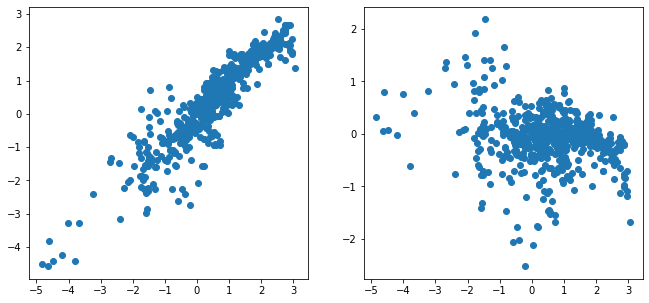

In [205]:
print('FreeSolv KRR JB JB')
y_pred = KRR_JB_JB.predict(FS_JB_JB.X)
y_true = FS_JB_JB.y
MSE_score = MSE(y_true, y_pred)
RMS = MSE_score**0.5*norms['JB_JB']['G'][0]
print(f'RMS: {float(RMS):.3f}')
plot_one(np.squeeze(y_true), y_pred)

# Permutation Importance

## KRR JB JB

### With fit

In [104]:
control = {}
for name in ('train', 'val', 'solvent', 'solute'):
    y_true = MnSol_datasets['JB_JB'][name].y
    y_pred = KRR_JB_JB.predict(MnSol_datasets['JB_JB'][name].X)
    control[name] = MSE(y_true, y_pred)

In [105]:
length = len(MnSol_datasets['JB_JB']['train'].X[0])
scores = {'fit':[], 'feat_zero': [], 'feat_rand': []}
important_features = {'fit':[], 'feat_zero': [], 'feat_rand': []}
fi_scores = {'fit': {}, 'feat_zero': {}, 'feat_rand': {}}
KRR_fi = []
for i in tqdm(range(length)):
    mask = np.array([1,] * length)
    mask[i] = 0
    X = [np.array(x)*mask for x in MnSol_datasets['JB_JB']['train'].X]
    y = MnSol_datasets['JB_JB']['train'].y
    KRR_i = clone(KRR_JB_JB)
    KRR_fi.append(KRR_i)
    KRR_fi[i].fit(X, y)
    sc = {}

    for name in MnSol_datasets['JB_JB']:
        X = [x*mask for x in MnSol_datasets['JB_JB'][name].X]
        y_true = MnSol_datasets['JB_JB'][name].y
        y_pred = KRR_fi[i].predict(X)
        sc[name] = MSE(y_true, y_pred)

    scores['fit'].append(sc)

for name in ('train', 'val', 'solvent', 'solute'):
    fi_scores['fit'][name] = [scores['fit'][i][name]-control[name] for i in range(length)]

100%|██████████| 564/564 [21:47<00:00,  2.32s/it]


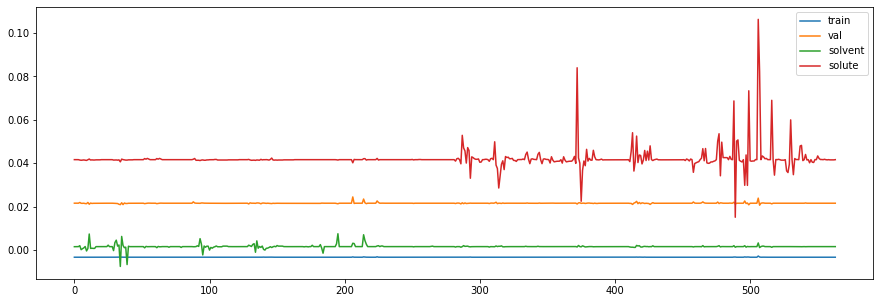

In [106]:
plt.figure(figsize=(15,5))
for name in ('train', 'val', 'solvent', 'solute'):
    plt.plot(fi_scores['fit'][name])
plt.legend(('train', 'val', 'solvent', 'solute'))
plt.show()


### Without Fit Zeros

In [107]:
length = len(MnSol_datasets['JB_JB']['train'].X[0])
for i in  tqdm(range(length)):
    mask = np.array([1,] * length)
    mask[i] = 0
    sc = {}
 
    for name in MnSol_datasets['JB_JB']:
        X = [np.array(x)*mask for x in MnSol_datasets['JB_JB'][name].X]
        y_true = MnSol_datasets['JB_JB'][name].y
        y_pred = KRR_JB_JB.predict(X)
        sc[name] = MSE(y_true, y_pred)

    scores['feat_zero'].append(sc)

100%|██████████| 564/564 [13:46<00:00,  1.47s/it]


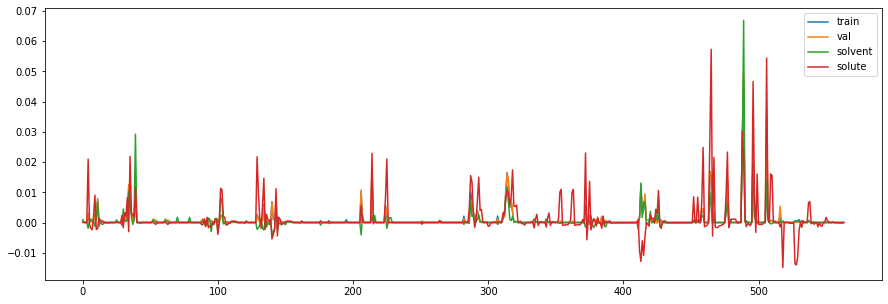

In [108]:
for name in ('train', 'val', 'solvent', 'solute'):
    fi_scores['feat_zero'][name] = [scores['feat_zero'][i][name]-control[name] for i in range(length)]

plt.figure(figsize=(15, 5))
for name in ('train', 'val', 'solvent', 'solute'):
    plt.plot(fi_scores['feat_zero'][name])
plt.legend(('train', 'val', 'solvent', 'solute'))
plt.show()


### Without Fit Random

In [109]:
length = len(MnSol_datasets['JB_JB']['train'].X[0])
for i in tqdm(range(length)):
    mask = np.array([1,] * length)
    mask[i] = np.random.normal(loc=0, scale=1,size=None)
    sc = {}

    for name in MnSol_datasets['JB_JB']:
        X = [np.array(x)*mask for x in MnSol_datasets['JB_JB'][name].X]
        y_true = MnSol_datasets['JB_JB'][name].y
        y_pred = KRR_JB_JB.predict(X)
        sc[name] = MSE(y_true, y_pred)

    scores['feat_rand'].append(sc)



100%|██████████| 564/564 [14:03<00:00,  1.50s/it]


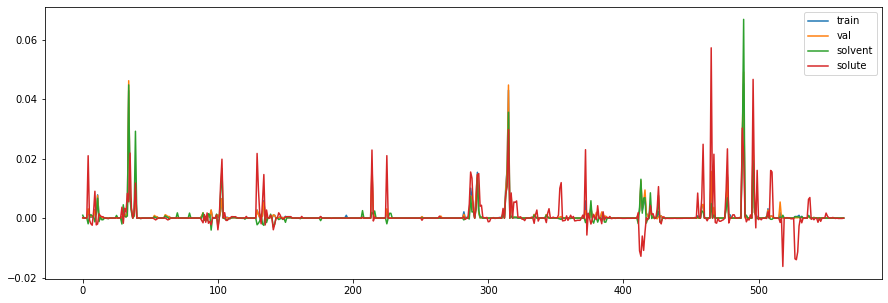

In [110]:
for name in ('train', 'val', 'solvent', 'solute'):
    fi_scores['feat_rand'][name] = [scores['feat_rand'][i][name]-control[name] for i in range(length)]

plt.figure(figsize=(15, 5))
for name in ('train', 'val', 'solvent', 'solute'):
    plt.plot(fi_scores['feat_rand'][name])
plt.legend(('train', 'val', 'solvent', 'solute'))
plt.show()

In [112]:
with open(project_path('Solvation_1/Tables/Feat_importance_scores.pkl'), 'wb') as f:
    pkl.dump(fi_scores, f)

In [113]:
n_feat = 20
for method in fi_scores:
    for v in (-np.array(fi_scores[method]['solute'])).argsort()[:n_feat]:
        if v < 282:
            compound = 'S: Solvent'
            b = JB_bag_i[v]
        else:
            compound = 'U: Solute'
            b = JB_bag_i[v-282]
        important_features[method].append((compound, b[0], b[1], fi_scores[method]['solute'][v]))

In [251]:
FI_pd = pd.DataFrame({name:[v[:3] for v in values] for name, values in important_features.items()})
FI_pd

## KRR Class Morgan

In [199]:
control2 = {}
for name in ('train', 'val', 'solvent', 'solute'):
    y_true = MnSol_datasets['Class_Morgan'][name].y
    y_pred = KRR_Class_Morgan.predict(MnSol_datasets['Class_Morgan'][name].X)
    control2[name] = MSE(y_true, y_pred)

In [198]:
length = len(MnSol_datasets['Class_Morgan']['train'].X[0])
scores2 = {'fit':[], 'feat_zero': [], 'feat_rand': []}
important_features2 = {'fit':[], 'feat_zero': [], 'feat_rand': []}
fi_scores2 = {'fit': {}, 'feat_zero': {}, 'feat_rand': {}}
for i in  tqdm(range(length)):
    mask = np.array([1,] * length)
    mask[i] = 0
    sc = {}

    for name in MnSol_datasets['Class_Morgan']:
        X = [np.array(x)*mask for x in MnSol_datasets['Class_Morgan'][name].X]
        y_true = MnSol_datasets['Class_Morgan'][name].y
        y_pred = KRR_Class_Morgan.predict(X)
        sc[name] = MSE(y_true, y_pred)

    scores2['feat_zero'].append(sc)

100%|██████████| 207/207 [02:21<00:00,  1.46it/s]


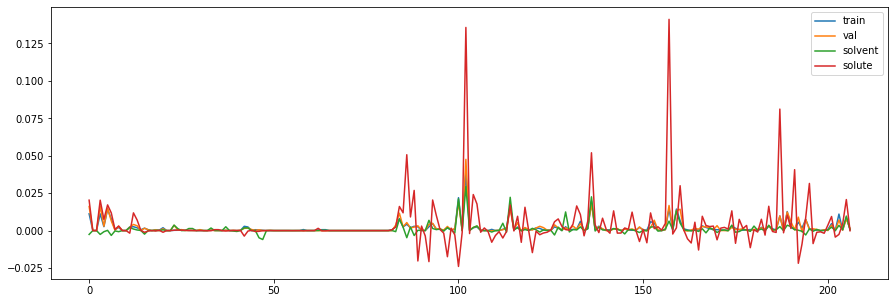

In [200]:
for name in ('train', 'val', 'solvent', 'solute'):
    fi_scores2['feat_zero'][name] = [scores2['feat_zero'][i][name]-control2[name] for i in range(length)]

plt.figure(figsize=(15, 5))
for name in ('train', 'val', 'solvent', 'solute'):
    plt.plot(fi_scores2['feat_zero'][name])
plt.legend(('train', 'val', 'solvent', 'solute'))
plt.show()

In [ ]:
n_feat = 20
for method in fi_scores2:
    for v in (-np.array(fi_scores2[method]['solute'])).argsort()[:n_feat]:
        if v < 282:
            compound = 'S: Solvent'
            b = JB_bag_i[v]
        else:
            compound = 'U: Solute'
            b = JB_bag_i[v-282]
        important_features2[method].append((compound, b[0], b[1], fi_scores2[method]['solute'][v]))

## LinNet Class Morgan

In [241]:
control3 = {}
for name in ('train', 'val', 'solvent', 'solute'):
    y_true = MnSol_datasets['Class_Morgan'][name].y
    Xs = [torch.unsqueeze(torch.tensor(X), dim=0) for X in MnSol_datasets['Class_Morgan'][name].X]
    y_pred = np.array([float(LinNet_Class_Morgan(X)) for X in Xs])
    control3[name] = MSE(y_true, y_pred)

In [245]:
length = len(MnSol_datasets['Class_Morgan']['train'].X[0])
scores3 = {'fit':[], 'feat_zero': [], 'feat_rand': []}
important_features3 = {'fit':[], 'feat_zero': [], 'feat_rand': []}
fi_scores3 = {'fit': {}, 'feat_zero': {}, 'feat_rand': {}}
for i in  tqdm(range(length)):
    mask = np.array([1,] * length)
    mask[i] = 0
    sc = {}

    for name in MnSol_datasets['Class_Morgan']:
        Xs = [torch.unsqueeze(torch.tensor(np.array(x)*mask).float(), dim=0) for x in MnSol_datasets['Class_Morgan'][name].X]
        y_true = MnSol_datasets['Class_Morgan'][name].y
        y_pred = np.array([float(LinNet_Class_Morgan(X)) for X in Xs])
        sc[name] = MSE(y_true, y_pred)

    scores3['feat_zero'].append(sc)

100%|██████████| 207/207 [00:30<00:00,  6.89it/s]


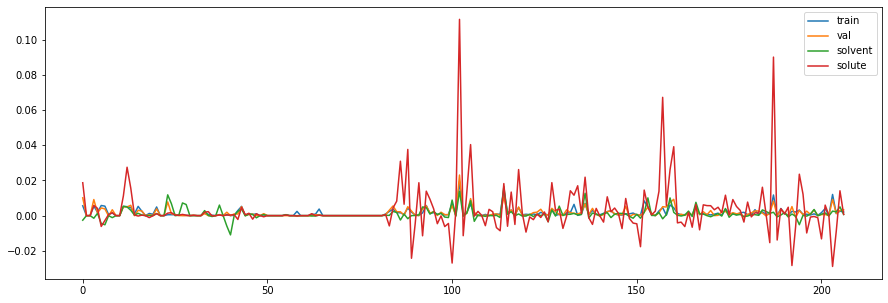

In [246]:
for name in ('train', 'val', 'solvent', 'solute'):
    fi_scores3['feat_zero'][name] = [scores3['feat_zero'][i][name]-control3[name] for i in range(length)]

plt.figure(figsize=(15, 5))
for name in ('train', 'val', 'solvent', 'solute'):
    plt.plot(fi_scores3['feat_zero'][name])
plt.legend(('train', 'val', 'solvent', 'solute'))
plt.show()

In [ ]:
n_feat = 20
for method in fi_scores3:
    for v in (-np.array(fi_scores3[method]['solute'])).argsort()[:n_feat]:
        if v < 83:
            compound = 'S: Solvent'
            b = Class_to_i[v]
        else:
            compound = 'U: Solute'
            b = JB_bag_i[v-282]
        important_features2[method].append((compound, b[0], b[1], fi_scores2[method]['solute'][v]))

# Figures

## Distribution

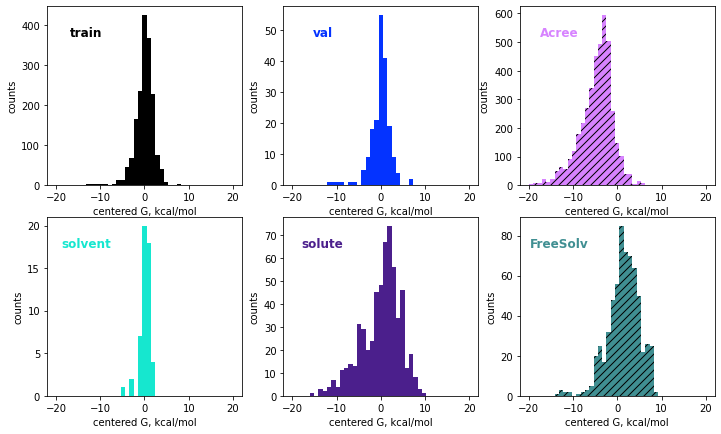

In [53]:
sp = (231, 232, 234, 235, 233, 236)
colors = ['black', '#0433FF', '#16E7CF', '#4B1F8C', '#D783FF', '#408F92']
labels = ['train', 'val', 'solvent', 'solute', 'Acree', 'FreeSolv']
ds = (train_dataset, val_dataset, solvent_test_dataset, solute_test_dataset, Acree_JB_JB, FS_JB_JB)
plt.subplots(2,3, figsize=(10, 6))
plt.style='scientific'
plt.tight_layout()
for i in range(6):
    plt.subplot(sp[i])
    plt.xlabel('centered G, kcal/mol')
    plt.ylabel('counts')
    # plt.text(0, 0 , labels[i], verticalalignment='top', horizontalalignment='left')
    # plt.title(labels[i], verticalalignment='top', horizontalalignment='left')
    # plt.text(.5,.9,labels[i],
    #     horizontalalignment='left')
    plt.title(labels[i], x=0.2, y=0.8, color=colors[i], fontweight = 'bold')
    if type(ds[i].y) is list:
        yyy = [y*2.8032 for y in ds[i].y]
        h=None
    else:
        yyy =  [y*2.8032 for y in np.squeeze(ds[i].y)]
        h='///'
    plt.hist(yyy, bins=41, range=(-20,20), color=colors[i], hatch=h)

plt.savefig('/Users/balepka/Downloads/All_distr.png', dpi=300, bbox_inches='tight')

## Scores

### Class Morgan KRR

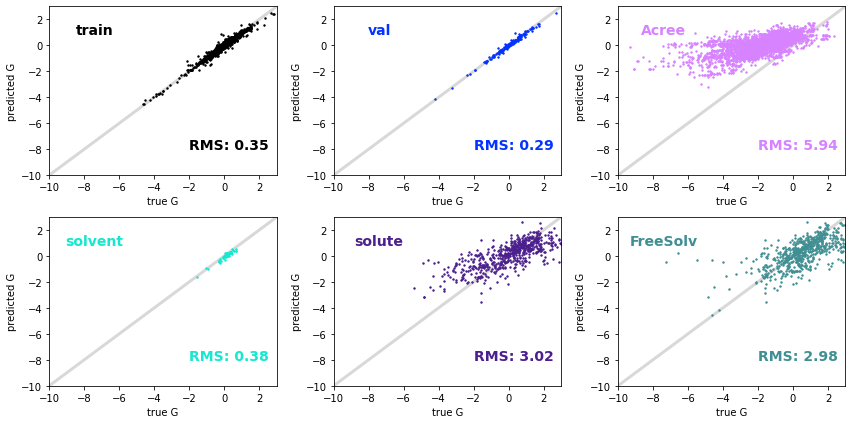

In [102]:
sp = (231, 232, 234, 235, 233, 236)
limits = (-10,3)
colors = ['black', '#0433FF', '#16E7CF', '#4B1F8C', '#D783FF', '#408F92']
labels = ['train', 'val', 'solvent', 'solute', 'Acree', 'FreeSolv']
plt.subplots(2,3, figsize=(12, 6))
plt.style='scientific'
for i in range(6):
    plt.subplot(sp[i])
    plt.xlabel('true G')
    plt.ylabel('predicted G')
    plt.title(labels[i], x=0.2, y=0.8, color=colors[i], fontweight = 'bold', fontsize=14)

    if i<4:
        ds = MnSol_datasets['Class_Morgan'][labels[i]]
        y_true = ds.y
    else:
        ds = (Acree_Class_Morgan if labels[i]=='Acree' else FS_Class_Morgan)
        y_true = np.squeeze(ds.y)

    y_pred = KRR_Class_Morgan.predict(ds.X)
    MSE_score = MSE(y_true, y_pred)
    RMS = MSE_score**0.5*norms['Class_Morgan']['G'][0]

    plt.text(x=-2, y=-8, s=f'RMS: {float(RMS):.2f}',color=colors[i], fontweight = 'bold', fontsize=14)

    plt.plot(limits, limits, linewidth=3, color='grey', zorder=1, alpha=0.3)
    plt.scatter(y_true, y_pred, color=colors[i], s=2, marker='o', zorder=2)
    plt.xlim(limits)
    plt.ylim(limits)

plt.tight_layout()
plt.savefig('/Users/balepka/Downloads/True_Pred_All_KRR_ClMor.png', dpi=300, bbox_inches='tight')

### JB JB KRR

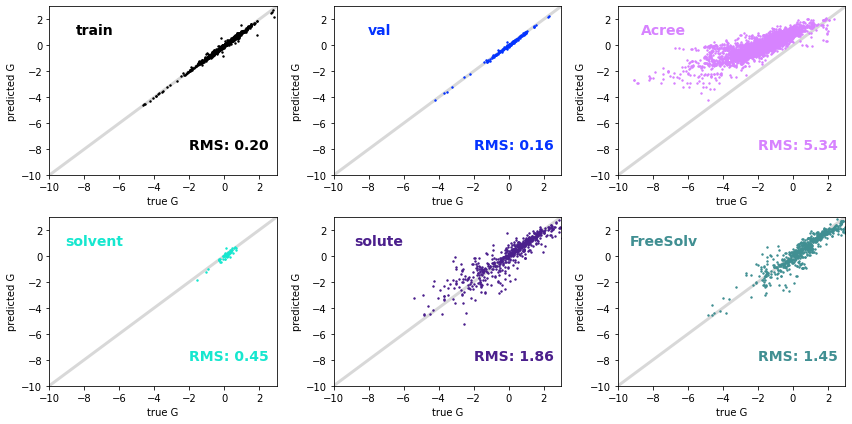

In [101]:
sp = (231, 232, 234, 235, 233, 236)
limits = (-10,3)
colors = ['black', '#0433FF', '#16E7CF', '#4B1F8C', '#D783FF', '#408F92']
labels = ['train', 'val', 'solvent', 'solute', 'Acree', 'FreeSolv']
plt.subplots(2,3, figsize=(12, 6))
plt.style='scientific'
for i in range(6):
    plt.subplot(sp[i])
    plt.xlabel('true G')
    plt.ylabel('predicted G')
    plt.title(labels[i], x=0.2, y=0.8, color=colors[i], fontweight = 'bold', fontsize=14)

    if i<4:
        ds = MnSol_datasets['JB_JB'][labels[i]]
        y_true = ds.y
    else:
        ds = (Acree_JB_JB if labels[i]=='Acree' else FS_JB_JB)
        y_true = np.squeeze(ds.y)

    y_pred = KRR_JB_JB.predict(ds.X)
    MSE_score = MSE(y_true, y_pred)
    RMS = MSE_score**0.5*norms['JB_JB']['G'][0]

    plt.text(x=-2, y=-8, s=f'RMS: {float(RMS):.2f}',color=colors[i], fontweight = 'bold', fontsize=14)

    plt.plot(limits, limits, linewidth=3, color='grey', zorder=1, alpha=0.3)
    plt.scatter(y_true, y_pred, color=colors[i], s=2, marker='o', zorder=2)
    plt.xlim(limits)
    plt.ylim(limits)

plt.tight_layout()
plt.savefig('/Users/balepka/Downloads/True_Pred_All_KRR_JB.png', dpi=300, bbox_inches='tight')

### Class Morgan LinNet

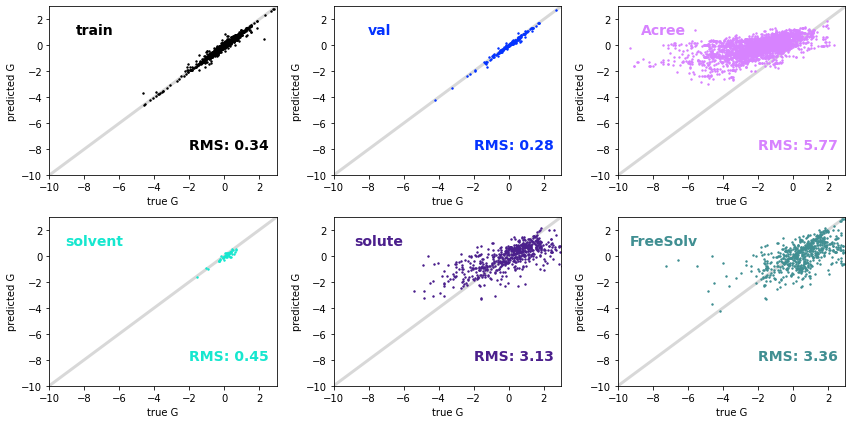

In [197]:
sp = (231, 232, 234, 235, 233, 236)
limits = (-10,3)
colors = ['black', '#0433FF', '#16E7CF', '#4B1F8C', '#D783FF', '#408F92']
labels = ['train', 'val', 'solvent', 'solute', 'Acree', 'FreeSolv']
plt.subplots(2,3, figsize=(12, 6))
plt.style='scientific'
for i in range(6):
    plt.subplot(sp[i])
    plt.xlabel('true G')
    plt.ylabel('predicted G')
    plt.title(labels[i], x=0.2, y=0.8, color=colors[i], fontweight = 'bold', fontsize=14)

    if i<4:
        ds = MnSol_datasets['Class_Morgan'][labels[i]]
        y_true = ds.y
    else:
        ds = (Acree_Class_Morgan if labels[i]=='Acree' else FS_Class_Morgan)
        y_true = np.squeeze(ds.y)

    Xs = [torch.unsqueeze(torch.tensor(X), dim=0) for X in ds.X]
    y_pred = np.array([float(LinNet_Class_Morgan(X)) for X in Xs])


    MSE_score = MSE(y_true, y_pred)
    RMS = MSE_score**0.5*norms['Class_Morgan']['G'][0]

    plt.text(x=-2, y=-8, s=f'RMS: {float(RMS):.2f}',color=colors[i], fontweight = 'bold', fontsize=14)

    plt.plot(limits, limits, linewidth=3, color='grey', zorder=1, alpha=0.3)
    plt.scatter(y_true, y_pred, color=colors[i], s=2, marker='o', zorder=2)
    plt.xlim(limits)
    plt.ylim(limits)

plt.tight_layout()
plt.savefig('/Users/balepka/Downloads/True_Pred_All_LinNet_ClMor.png', dpi=300, bbox_inches='tight')

## Permutation Importance

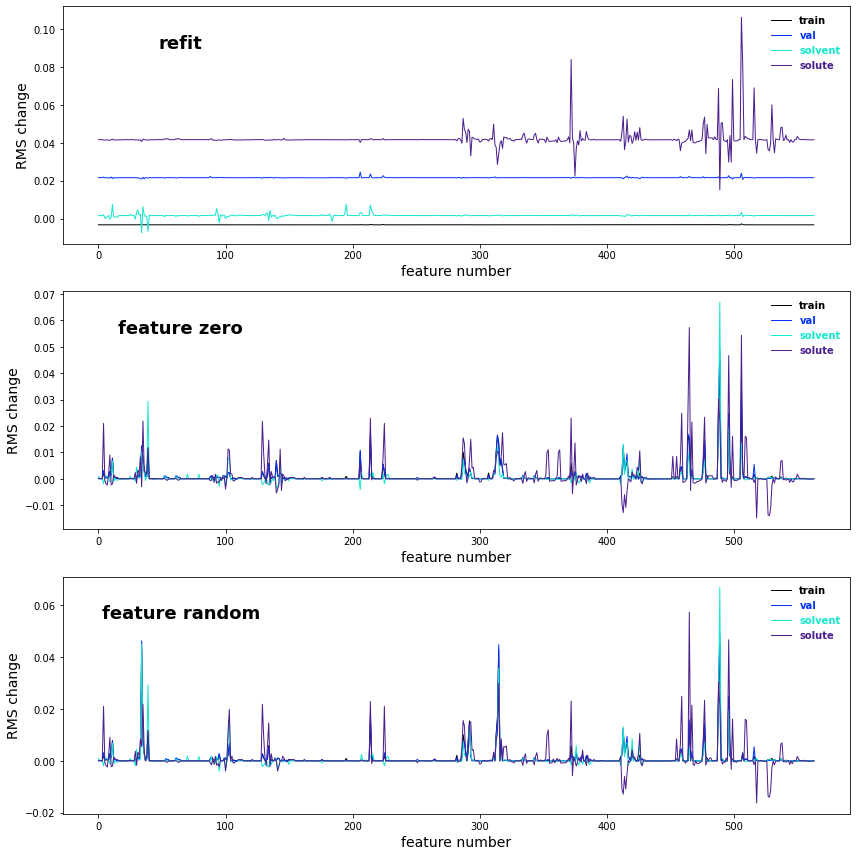

In [143]:
sp = (311, 312, 313, 235, 233, 236)
plt.subplots(3,1, figsize=(12, 12))
plt.style='scientific'
labels = ['refit', 'feature zero', 'feature random']
methods = ['fit', 'feat_zero', 'feat_rand']
colors = {'train':'black', 'val':'#0433FF', 'solvent':'#16E7CF', 'solute':'#4B1F8C'}
for i in range(3):
    plt.subplot(sp[i])
    plt.xlabel('feature number', fontsize=14)
    plt.ylabel('RMS change', fontsize=14)
    plt.title(labels[i], x=0.15, y=0.8, fontweight = 'bold', fontsize=18)


    for name in ('train', 'val', 'solvent', 'solute'):
        plt.plot(fi_scores[methods[i]][name], color=colors[name], linewidth=1)
        plt.legend(('train', 'val', 'solvent', 'solute'), frameon=False, labelcolor='linecolor', fontsize=14, loc='upper right',prop=dict(weight='bold'))

plt.tight_layout()
plt.savefig('/Users/balepka/Downloads/Feature_imp.png', dpi=300, bbox_inches='tight')
plt.show()

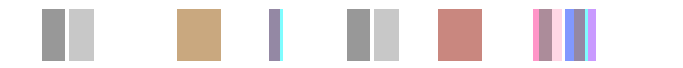

In [412]:
# Create bag mask 
# n_feat = 20
# twenty_feat = sorted(list((-np.array(fi_scores['feat_zero']['solute'])).argsort()[:n_feat]))
# 
# cb = {'S':[], 'U':[]}
# for f in twenty_feat:
#     if f < 282:
#         d = 'S'
#         fff = f
#     else:
#         d = 'U'
#         fff = f-282
#     cb[d].append(JB_bag_i[fff][0])
# 
# cb2 = {}
# for k, v in cb.items():
#     cb2[k] = set(v)
# 
# color_bags = {'C':'#333333', 'CC':'#929292', 'HC':'#945200', 'H':'#941100', 'N':'#FF2F92', 'NC':'#5A1B37', 'NH':'#FFB0CD', 'O':'#0433FF', 'OC':'#2A124B', 'OH':'#00FDFF', 'ON':'#9437FF'}
# 
# bags_borders = {}
# tracker = 0
# for bag, size in bagger.bag_sizes.items():
#     bags_borders[bag]=(tracker, tracker+size+1)
#     tracker += size+1
# 
# bins = [v[0] for k, v in bags_borders.items()]+ [v[0]+282 for k, v in bags_borders.items()] + [563,]
# 
# plt.figure(figsize=(12, 1))
# N, bin, patches = plt.hist(bins[:-1], bins=bins)
# # print(len(patches))
# for i in range(len(patches)):
#     if i<34:
#         bag = list(bagger.bags.keys())[i]
#         d='S'
#     else:
#         bag = list(bagger.bags.keys())[i-34]
#         d='U'
#     # print(bag, i)
#     if bag in cb2[d]:
#         patches[i].set_facecolor(color_bags[bag])
#         patches[i].set_alpha(0.5)
#     else:
#         patches[i].set_facecolor('white')
#         patches[i].set_alpha(0)
# 
# plt.axis('off')
# plt.savefig('/Users/balepka/Downloads/bags.png')